In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline
import os
import random
import csv
import cv2
import tensorflow as tf

train_images = []
with open('input/train/train2.csv', 'rt') as file:
    data = csv.reader(file)
    for row in data:
        img = row[0]
        train_images.append(img)
random.shuffle(train_images)

test_images = []
with open('input/test_ApKoW4T.csv', 'rt') as file:
    data = csv.reader(file)
    for row in data:
        img = row[0]
        test_images.append(img)
random.shuffle(test_images)

In [3]:
nrows = 150
ncols = 150
channels = 3

def read_process_image(image_list):
    X = [] # for resized images
    y = [] # for labels
    
    for image in image_list:
        exc = ""
        image_path = "input/train/images-5-class/" + image
        try:
            img = cv2.imread(image_path, cv2.IMREAD_COLOR)
            X.append(cv2.resize(img, (nrows, ncols), interpolation=cv2.INTER_CUBIC))
        except Exception as e:
            exc = image
            print(str(e))
            print(image_path)
        with open('input/train/train2.csv', 'rt') as file:
            data = csv.reader(file)
            for row in data:
                if row[0] == image:
                    label = row[1]
        if (exc != image):
            y.append(label)
    
    return X, y

In [4]:
X, y = read_process_image(train_images)

In [5]:
train_files = pd.read_csv('input/train/train2.csv', names=['image', 'category'])
train_files.head()

,image,category
0,2823080.jpg,1
1,2870024.jpg,1
2,2662125.jpg,2
3,2900420.jpg,3
4,2804883.jpg,2


In [6]:
test_files = pd.read_csv('input/test_ApKoW4T.csv', names=['image'])
test_files.head()

,image
0,1007700.jpg
1,1011369.jpg
2,1051155.jpg
3,1062001.jpg
4,1069397.jpg


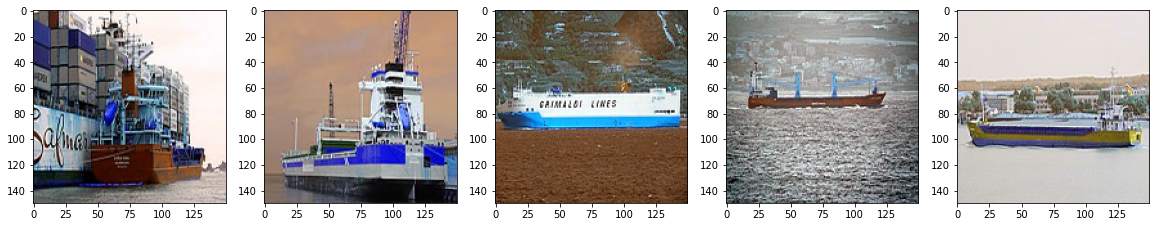

In [7]:
plt.figure(figsize=(20,10))
columns = 5
for i in range(columns):
    plt.subplot(5 / columns + 1, columns, i + 1)
    plt.imshow(X[i])

Text(0.5, 1.0, 'Labels ships')

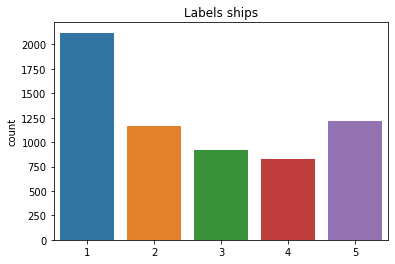

In [8]:
X = np.array(X)
y = np.array(y)

sns.countplot(y)
plt.title('Labels ships')

Labels
- 1: Cargo
- 2: Military
- 3: Carrier
- 4: Cruise
- 5: Tankers

In [9]:
print("Shape of train images is:", X.shape)
print("Shape of labels is:", y.shape)

Shape of train images is: (6252, 150, 150, 3)
Shape of labels is: (6252,)


In [10]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

encoder = LabelEncoder()
encoder.fit(y)
encoded_Y = encoder.transform(y)
y = np_utils.to_categorical(encoded_Y)

Using TensorFlow backend.


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=2)

In [12]:
import gc

gc.collect()

ntrain = len(X_train)
nval = len(X_val)

batch_size = 32

In [13]:
from keras.applications import VGG19

conv_base = VGG19(weights='imagenet', include_top=False, input_shape=(150,150,3))
# conv_base = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(150,150,3))

80142336/80134624 [==============================] - 109s 1us/step


In [14]:
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [22]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_5 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 1285      
Total params: 22,188,869
Trainable params: 2,164,485
Non-trainable params: 20,024,384
_________________________________________________________________


In [24]:
print('Number of trainable weights before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('Number of trainable weights after freezing the conv base:', len(model.trainable_weights))

Number of trainable weights before freezing the conv base: 6
Number of trainable weights after freezing the conv base: 6


In [25]:
from keras import optimizers

model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])

In [26]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

In [27]:
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

In [ ]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=ntrain // batch_size,
                              epochs=50,
                              validation_data=val_generator,
                              validation_steps=nval // batch_size)

Epoch 1/50
156/156 [==============================] - 405s 3s/step - loss: 1.3732 - acc: 0.4313 - val_loss: 1.1180 - val_acc: 0.5721
Epoch 2/50
156/156 [==============================] - 400s 3s/step - loss: 1.1101 - acc: 0.5669 - val_loss: 0.9444 - val_acc: 0.6161
Epoch 3/50
156/156 [==============================] - 354s 2s/step - loss: 0.9804 - acc: 0.6202 - val_loss: 0.6046 - val_acc: 0.6399
Epoch 4/50
156/156 [==============================] - 368s 2s/step - loss: 0.8885 - acc: 0.6522 - val_loss: 0.8697 - val_acc: 0.6989
Epoch 5/50
156/156 [==============================] - 382s 2s/step - loss: 0.8324 - acc: 0.6848 - val_loss: 0.6874 - val_acc: 0.7350
Epoch 6/50
156/156 [==============================] - 388s 2s/step - loss: 0.8180 - acc: 0.6780 - val_loss: 0.5616 - val_acc: 0.7326
Epoch 7/50
156/156 [==============================] - 378s 2s/step - loss: 0.7741 - acc: 0.6921 - val_loss: 0.6223 - val_acc: 0.7449
Epoch 8/50
155/156 [============================>.] - ETA: 1s - loss:

In [ ]:
model.save_weights('model_weights_vgg19.h5')
# model.save_weights('model_weights_inception_resnet_v2.h5')
model.save('model_keras_inception_resnet_v2.h5', include_optimizer=False) # to get rid of load_model 'saved optimizer' warning

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [ ]:
def smooth_plot(points, factor=0.7):
    smooth_pts = []
    for point in points:
        if smooth_pts:
            previous = smooth_pts[-1]
            smooth_pts.append(previous * factor + point * (1 - factor))
        else:
            smooth_pts.append(point)
    return smooth_pts

In [ ]:
plt.plot(epochs, smooth_plot(acc), 'b', label='Training accurarcy')
plt.plot(epochs, smooth_plot(val_acc), 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()
plt.show()

In [ ]:
test_images = []
with open('input/test.csv', 'rt') as file:
    data = csv.reader(file)
    for row in data:
        img = row[0]
        test_images.append(img)

In [ ]:
nrows = 150
ncolumns = 150
channels = 3

def read_process_image(image_list):
    X = [] # for resized images
    y = [] # for labels
    
    for image in image_list:
        exc = ""
        image_path = "input/train/images/" + image
        try:
            img = cv2.imread(image_path, cv2.IMREAD_COLOR)
            X.append(cv2.resize(img, (nrows, ncolumns), interpolation=cv2.INTER_CUBIC))
        except Exception as e:
            exc = image
            print(str(e))
    
    return X, y

In [ ]:
X_test, y_test = read_process_image(test_images[0:10])
x = np.array(X_test)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
from keras.models import load_model
model = load_model('model_keras.h5')

In [ ]:
i = 0
columns = 5
text_labels = []
convert_label_dict = {'1': 'Cargo', 
                      '2': 'Military', 
                      '3': 'Carrier', 
                      '4': 'Cruise', 
                      '5': 'Tankers', 
                      '6': 'Container Ship', 
                      '7': 'Bulk Carrier', 
                      '8': 'Passengers Ship', 
                      '9': 'Reefer', 
                      '10': 'Yacht'}
plt.figure(figsize=(30,20))

for batch in test_datagen.flow(x, batch_size=1):
    pred = model.predict(batch)
    pred_label = np.argmax(pred)

    text_labels.append(str(pred_label))
    print(text_labels)
    plt.subplot(15 / columns + 1, columns, i + 1)
    plt.title('This is a ' + convert_label_dict.get(text_labels[i]))
    imgplot = plt.imshow(batch[0])
    i += 1
    if i % 20 == 0:
        break

plt.show()